# plotting spaceweather keywords with python + d3

In this notebook, we will be plotting spaceweather keywords calculated from the Helioseismic and Magnetic Imager instrument on NASA's Solar Dynamics Observatory (SDO) satellite using <a  href="https://mpld3.github.io/">mpld3</a>, a python interface for <a  href="http://d3js.org/">d3</a>. SDO takes about a terabyte and a half of data a day, which is more data than any other satellite in NASA history; these data are stored in a pSQL database at Stanford University. We will access this database via a JSON query.

First, we'll import some modules.

In [1]:
import json, urllib, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick, mpld3
from datetime import datetime as dt_obj
from matplotlib.dates import *
%matplotlib inline
%config InlineBackend.figure_format='retina'

Now we'll execute a sample JSON query using the json and urllib modules. In theory, it is possible to parse JSON queries using the <code>read_json()</code> function in the pandas library, but, in practice, the object returned by the JSON API for the SDO database, <code>jsoc_info</code>, isn't formatted in a way that <code>pandas.read_json()</code> can understand easily.

In [2]:
url = "http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?ds=hmi.sharp_720s[377][2011.02.14_02:00:00/1d]&op=rs_list&key=T_REC,USFLUX,ERRVF"
response = urllib.urlopen(url)
data = json.loads(response.read())

Now we'll create some empty lists to hold the data:

In [3]:
usflux = [] # this holds the keyword USFLUX
errvf =  [] # this holds the keyword ERRVF
t_rec  = [] # this holds the keyword T_REC

<code>data</code> is of type dict, so we'll get the number of keyword elements this way:

In [4]:
n_elements = len(data['keywords'][1]['values'])

And then we'll populate our empty lists to hold the keyword values:

In [5]:
for i in range(n_elements):
    usflux.append(float(data['keywords'][1]['values'][i]))

for i in range(n_elements):
    t_rec.append(data['keywords'][0]['values'][i])

for i in range(n_elements):
    errvf.append(float(data['keywords'][2]['values'][i]))

Let's convert our lists to numpy arrays, because they're easier to work with:

In [6]:
usflux = np.array(usflux)
errvf  = np.array(errvf)
t_rec  = np.array(t_rec,dtype='S16') # this dtype is ok to set as the format of T_REC will never change

T_REC is formatted in a way that matplotlib.pyplot will not understand, so let's convert the numpy array into a datetime object:

In [7]:
# original parse_tai_string function written by C. Baldner
# (the function below represents a modification)
def parse_tai_string(tstr,datetime=True):
    year   = int(tstr[:4])
    month  = int(tstr[5:7])
    day    = int(tstr[8:10])
    hour   = int(tstr[11:13])
    minute = int(tstr[14:16])
    if datetime: return dt_obj(year,month,day,hour,minute)
    else: return year,month,day,hour,minute

x = np.array([parse_tai_string(t_rec[i],datetime=True) for i in range(t_rec.size)])

Now for some plotting! matplotlib.pyplot generates two objects: a figure and axes. The data are ascribed to the axes. The time axes in particular requires some formatting; in order to free it of clutter, we'll plot tick marks every six hours and label them accordingly.

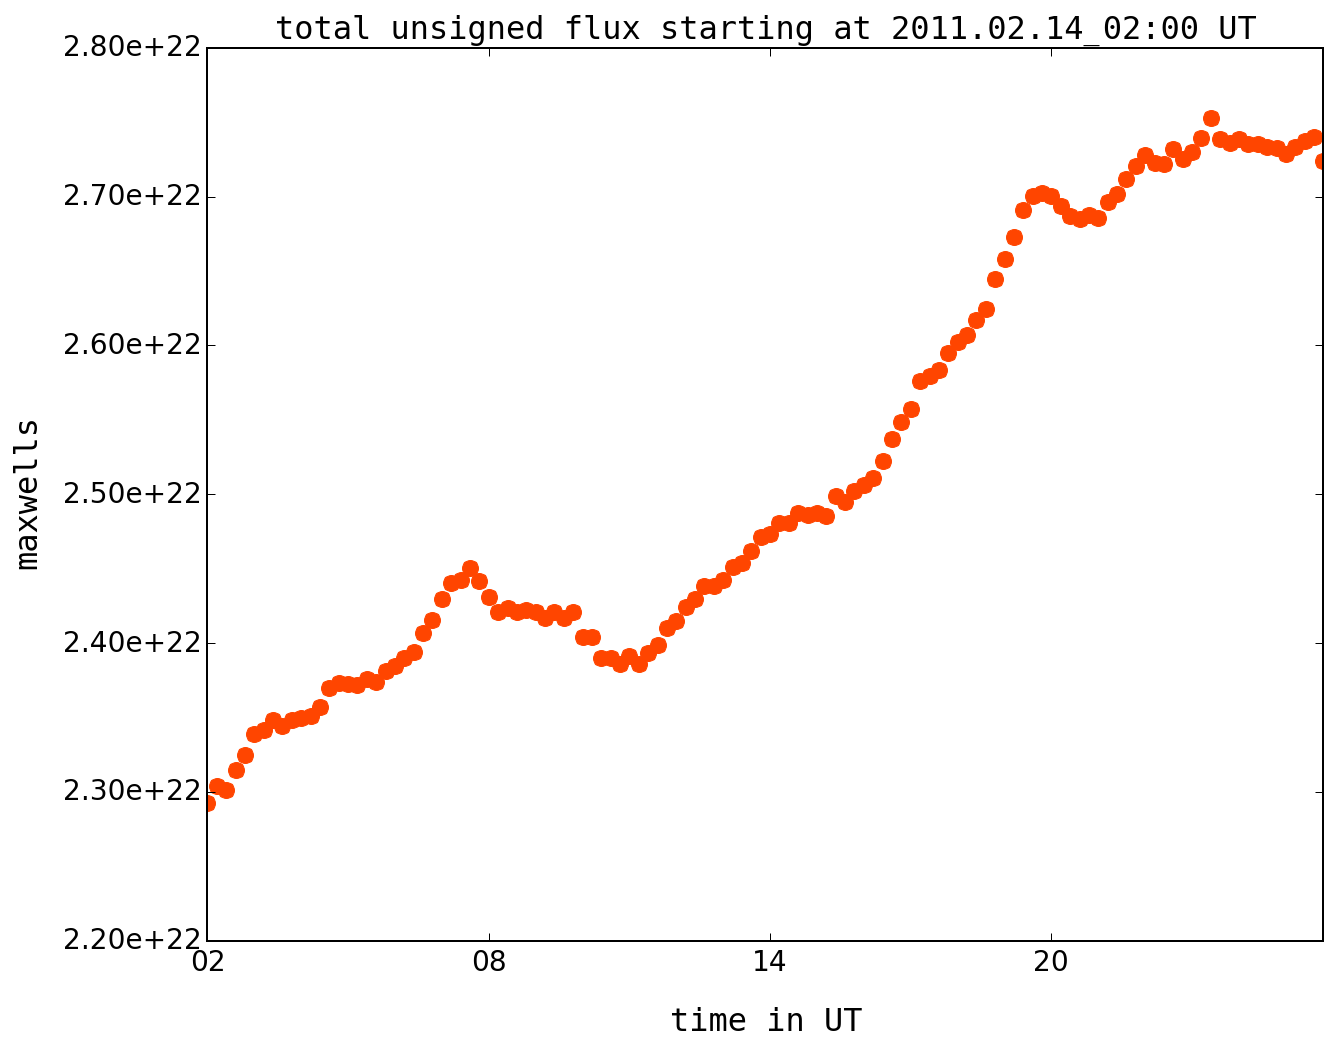

In [8]:
fig, ax = plt.subplots(figsize=(10,8))      # define the size of the figure
orangered = (1.0,0.27,0,1.0)                # create an orange-red color

# define some style elements
marker_style = dict(linestyle='', markersize=8, fillstyle='full',color=orangered,markeredgecolor=orangered)
text_style = dict(fontsize=16, fontdict={'family': 'monospace'})
ax.tick_params(labelsize=14)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))

# ascribe the data to the axes
ax.errorbar(x, usflux, yerr=errvf, linestyle='',color=orangered)
ax.plot(x, usflux,'o',**marker_style)

# format the x-axis with universal time
locator = AutoDateLocator()
locator.intervald[HOURLY] = [6] # only show every 6 hours
formatter = DateFormatter('%H')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# label the axes and the plot
ax.set_xlabel('time in UT',**text_style)
ax.set_ylabel('maxwells',**text_style)
ax.xaxis.labelpad=15
ax.yaxis.labelpad=10
ax.set_title('total unsigned flux starting at '+t_rec[0]+' UT',**text_style) # annotate the plot with a start time

Yaay! But we can do better by generating an interactive plot that runs on d3. The d3 plot generates three buttons in the lower left-hand corner: home, pan, and zoom. This allows us to explore the plot in detail (for example, zoom in significantly to see the error bars).

We can also generate the html to put this visualization on any website using the following command:  
<code>print(mpld3.fig_to_html(fig, template_type="simple"))</code>.

In [9]:
from mpld3 import plugins
mpld3.enable_notebook()
mpld3.display(fig)